<a href="https://colab.research.google.com/github/hzchzc123123/CTR/blob/main/DIN%E5%AE%9E%E6%88%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torchkeras
!pip install -q accelerate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 12.1 MB/s eta 0:00:00


In [ ]:

import numpy as np
import pandas as pd
import heapq

import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

from collections import Counter,OrderedDict
from tqdm import tqdm
from itertools import chain
import os,sys,time
from accelerate import Accelerator
from copy import deepcopy

import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchkeras import summary, KerasModel
from torchkeras.metrics import AUC


import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


数据导入以及删除一些类似于网站这种显然没用的特征，特征值初步处理

In [ ]:
dataset_dir = "/content/drive/MyDrive/CRT/Neural CF/NeuralCF/archive/"
credits = pd.read_csv(dataset_dir + 'credits.csv')
keywords = pd.read_csv(dataset_dir + 'keywords.csv')
movies = pd.read_csv(dataset_dir + 'movies_metadata.csv').\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587]) # Incorrect data type

movies['id'] = movies['id'].astype('int64')

df = movies.merge(keywords, on='id').\
    merge(credits, on='id')

df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

In [ ]:
df.head(5)

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,cast,crew
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


将一些包含了很多信息的单元格特征简化（提取名字）或者分开

In [ ]:
def get_text(text, obj='name'): #返回以name为键下的值
    text = literal_eval(text)

    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)

df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

# New columns
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df.drop('cast', axis=1, inplace=True)
df.drop('original_title', axis=1, inplace=True)
df.drop('overview', axis=1, inplace=True)
df.drop('tagline', axis=1, inplace=True)
df = df.reset_index(drop=True)

In [ ]:
df['genres']

0         Animation, Comedy, Family
1        Adventure, Fantasy, Family
2                   Romance, Comedy
3            Comedy, Drama, Romance
4                            Comedy
                    ...            
45553        Drama, Action, Romance
45554                         Drama
45555       Action, Drama, Thriller
45556                              
45557                              
Name: genres, Length: 45558, dtype: object

In [ ]:
df.head(5)

,adult,budget,genres,id,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors
0,False,30000000,"Animation, Comedy, Family",862,en,21.946943,Pixar Animation Studios,United States of America,1995-10-30,373554033.0,81.0,English,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,False,65000000,"Adventure, Fantasy, Family",8844,en,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,1995-12-15,262797249.0,104.0,"English, Français",6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,False,0,"Romance, Comedy",15602,en,11.7129,"Warner Bros., Lancaster Gate",United States of America,1995-12-22,0.0,101.0,English,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,False,16000000,"Comedy, Drama, Romance",31357,en,3.859495,Twentieth Century Fox Film Corporation,United States of America,1995-12-22,81452156.0,127.0,English,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,False,0,Comedy,11862,en,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,1995-02-10,76578911.0,106.0,English,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')
df =df.sort_values(by=['id'], ascending=[True])

In [ ]:
df.head(3)

,adult,budget,genres,id,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors
4353,False,0.0,"Drama, Crime",2,fi,3.860491,"Villealfa Filmproduction Oy, Finnish Film Foun...",Finland,1988-10-21,0.0,69.0,"suomi, Deutsch",7.1,44.0,"underdog, prison, factory worker, prisoner, he...","Aki Kaurismäki, Aki Kaurismäki, Timo Salminen,...","Taisto Olavi Kasurinen, Irmeli Katariina Pihla...","Turo Pajala, Susanna Haavisto, Matti Pellonpää..."
13015,False,0.0,"Drama, Comedy",3,fi,2.292110,Villealfa Filmproduction Oy,Finland,1986-10-16,0.0,76.0,"English, suomi, svenska",7.1,35.0,"salesclerk, helsinki, garbage, independent film","Aki Kaurismäki, Aki Kaurismäki, Timo Salminen,...","Nikander, Ilona Rajamäki, Melartin, Co-worker,...","Matti Pellonpää, Kati Outinen, Sakari Kuosmane..."
17,False,4000000.0,"Crime, Comedy",5,en,9.026586,"Miramax Films, A Band Apart",United States of America,1995-12-09,4300000.0,98.0,English,6.5,539.0,"hotel, new year's eve, witch, bet, hotel room,...","Combustible Edison, Gary Frutkoff, Lance Brown...","Ted the Bellhop, Man, Angela, Elspeth, Margare...","Tim Roth, Antonio Banderas, Jennifer Beals, Ma..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45558 entries, 4353 to 20237
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 45558 non-null  object        
 1   budget                45558 non-null  float64       
 2   genres                45558 non-null  object        
 3   id                    45558 non-null  int64         
 4   original_language     45558 non-null  object        
 5   popularity            45558 non-null  float64       
 6   production_companies  45558 non-null  object        
 7   production_countries  45558 non-null  object        
 8   release_date          45558 non-null  datetime64[ns]
 9   revenue               45558 non-null  float64       
 10  runtime               45558 non-null  float64       
 11  spoken_languages      45558 non-null  object        
 12  vote_average          45558 non-null  float64       
 13  vote_count   

In [ ]:
df.nunique()

adult                       2
budget                   1205
genres                   4045
id                      44404
original_language          90
popularity              42908
production_companies    22401
production_countries     2366
release_date            17184
revenue                  6845
runtime                   353
spoken_languages         1835
vote_average               92
vote_count               1820
keywords                25853
crew                    42158
characters              39400
actors                  41786
dtype: int64

In [ ]:
df[['vote_count','vote_average','revenue','runtime','budget','popularity']].describe()

,vote_count,vote_average,revenue,runtime,budget,popularity
count,45558.000000,45558.000000,4.555800e+04,45558.000000,4.555800e+04,45558.000000
mean,110.504280,5.637115,1.128389e+07,95.017472,4.257162e+06,2.949126
std,491.833183,1.897338,6.452507e+07,37.526643,1.746352e+07,6.007230
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,3.000000,5.000000,0.000000e+00,85.000000,0.000000e+00,0.402940
50%,10.000000,6.000000,0.000000e+00,95.000000,0.000000e+00,1.150270
75%,35.000000,6.800000,0.000000e+00,107.000000,0.000000e+00,3.743562
max,14075.000000,10.000000,2.787965e+09,1256.000000,3.800000e+08,547.488298


# Rating data

In [ ]:
ratings_df = pd.read_csv(dataset_dir + 'ratings.csv')
ratings_df = ratings_df.head(5000000)

In [ ]:
ratings_df['userId'] = ratings_df['userId'].astype(np.int)
ratings_df['movieId'] = ratings_df['movieId'].astype(np.int)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [ ]:
ratings_df

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
4999995,51433,661,5.0,1394863273
4999996,51433,783,4.0,1394863276
4999997,51433,1035,0.5,1394863180
4999998,51433,1320,5.0,1394863183


In [ ]:
user_movie_counts = ratings_df.groupby('userId')['movieId'].count()
users_with_more_than_20_ratings = user_movie_counts[user_movie_counts > 20].index
filtered_ratings_df = ratings_df[ratings_df['userId'].isin(users_with_more_than_20_ratings)]
ratings_df = filtered_ratings_df
ratings_df


,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
4999980,51432,6373,1.5,1074808840
4999981,51432,6378,3.5,1074808580
4999982,51432,6664,4.0,1074810071
4999983,51432,6711,2.5,1074809393


In [ ]:
train_ratings_df, test_ratings_df = train_test_split(ratings_df, test_size = 0.2, random_state=2020)
train_ratings_df = train_ratings_df.sort_values(
    by=['userId', 'timestamp'], ascending=[True, True])
test_ratings_df = test_ratings_df.sort_values(
    by=['userId', 'timestamp'], ascending=[True, True])
train_ratings_df

,userId,movieId,rating,timestamp
6,1,2762,4.5,1425941300
13,1,54503,3.5,1425941313
26,1,112552,5.0,1425941336
23,1,96821,5.0,1425941382
11,1,5577,5.0,1425941397
...,...,...,...,...
4999904,51432,1968,5.0,1074810047
4999907,51432,2134,4.5,1074810056
4999889,51432,1240,4.0,1074810064
4999950,51432,4306,4.0,1074810111


In [ ]:
test_ratings_df

,userId,movieId,rating,timestamp
15,1,59315,5.0,1425941502
2,1,858,5.0,1425941523
0,1,110,1.0,1425941529
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
4999984,51432,6953,4.0,1074809066
4999937,51432,3863,4.0,1074809265
4999871,51432,356,4.5,1074809824
4999919,51432,2791,4.5,1074809850


In [ ]:
filtered_df = test_ratings_df[(test_ratings_df['rating'] >= 3) & (test_ratings_df['userId'] == 1)]
filtered_df

,userId,movieId,rating,timestamp
15,1,59315,5.0,1425941502
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
7,1,2918,5.0,1425941593
14,1,58559,4.0,1425942007
21,1,91542,5.0,1425942618


In [ ]:
def mark_last_timestamp(df):
    last = df[['userId', 'movieId']].groupby(
        by='userId', as_index=False).tail(1).copy()
    last['last'] = 1
    df = pd.merge(
        df, last, how='left',
        on=['userId', 'movieId'])
    df.loc[~df['last'].isnull(), 'last'] = 1
    df.loc[df['last'].isnull(), 'last'] = 0

    return df

In [ ]:
train_ratings_df = mark_last_timestamp(train_ratings_df)
test_ratings_df = mark_last_timestamp(test_ratings_df)

In [ ]:
train_ratings_df

,userId,movieId,rating,timestamp,last
0,1,2762,4.5,1425941300,0.0
1,1,54503,3.5,1425941313,0.0
2,1,112552,5.0,1425941336,0.0
3,1,96821,5.0,1425941382,0.0
4,1,5577,5.0,1425941397,0.0
...,...,...,...,...,...
3807271,51432,1968,5.0,1074810047,0.0
3807272,51432,2134,4.5,1074810056,0.0
3807273,51432,1240,4.0,1074810064,0.0
3807274,51432,4306,4.0,1074810111,0.0


In [ ]:
candidate_movie_ids = train_ratings_df.movieId.values
candidate_movie_ids

array([  2762,  54503, 112552, ...,   1240,   4306,    333])

In [ ]:
# slow implement
def neg_sampling(candidates, filters, length):
    max_len = len(candidates)

    res = []
    for i in range(length):
        while(1):
            c = candidates[np.random.randint(0, max_len)]
            if c not in filters:
                res.append(str(c))
                filters.add(c)
                break
    return res

In [ ]:
def get_hist_movie_ids(df, max_len=10):
    hist_movie_ids = list()
    neg_hist_movie_ids = list()
    for _, group in df.groupby(by='userId'):
        tmp_hist_movie_ids = list()
        for _, row in group.iterrows():
            # keep high rated movies
            if row['rating'] >= 3 and row['last'] == 0:
                tmp_hist_movie_ids.append(str(int(row['movieId'])))
        # keep latest high rated movies
        tmp_hist_movie_ids.reverse()
        tmp_hist_movie_ids = tmp_hist_movie_ids[:max_len]
        # revert to timestamp order
        tmp_hist_movie_ids.reverse()
        tmp_neg_hist_movie_ids = neg_sampling(
            candidate_movie_ids, set(hist_movie_ids), len(tmp_hist_movie_ids))
        hist_movie_ids.append('|'.join(tmp_hist_movie_ids))
        neg_hist_movie_ids.append('|'.join(tmp_neg_hist_movie_ids))
    return hist_movie_ids, neg_hist_movie_ids

In [ ]:
train_hist_movie_ids, train_neg_hist_movie_ids = get_hist_movie_ids(train_ratings_df)
test_hist_movie_ids, test_neg_hist_movie_ids = get_hist_movie_ids(test_ratings_df)

In [ ]:
train_ratings_df = train_ratings_df[train_ratings_df['last'] == 1]
train_ratings_df['histHighRatedMovieIds'] = train_hist_movie_ids
train_ratings_df['negHistMovieIds'] = train_neg_hist_movie_ids


test_ratings_df = test_ratings_df[test_ratings_df['last'] == 1]
test_ratings_df['histHighRatedMovieIds'] = test_hist_movie_ids
test_ratings_df['negHistMovieIds'] = test_neg_hist_movie_ids

In [ ]:
train_ratings_df = train_ratings_df.dropna(subset=['histHighRatedMovieIds'])
train_ratings_df = train_ratings_df[train_ratings_df['histHighRatedMovieIds'] != '']
train_ratings_df

,userId,movieId,rating,timestamp,last,histHighRatedMovieIds,negHistMovieIds
18,1,73017,5.0,1425942699,1.0,4878|68358|2959|99114|33794|81834|69844|1968|4...,3006|2158|6104|2011|5995|2524|8640|235|88140|2968
36,2,339,5.0,867041296,1.0,141|5|260|1356|58|628|1210|605|1475|377,2422|7153|647|6686|281|96693|1653|1894|1923|5989
87,4,2338,2.0,1042674886,1.0,4226|4848|5679|1732|2875|1597|1645|648|4238|1422,6537|1881|508|3538|2019|4720|923|5630|1206|502
107,5,2877,1.0,949424482,1.0,3198|1263|750|541|1945|1201|1198|1225|908|1193,260|235|60979|8495|2995|99114|2080|1884|3897|2297
150,7,2858,4.5,1486254186,1.0,54503|69844|81834|88125|54272|98809|39183|8533...,288|203|30793|1198|122902|6639|55999|2806|2571...
...,...,...,...,...,...,...,...
3806737,51427,3814,4.0,1383052923,1.0,1244|858|111|593|296|541|1208|41285|1729|5954,35836|64983|2393|866|3996|4306|29|592|466|2890
3807049,51428,1389,1.0,997178206,1.0,2151|4625|1373|2950|4657|2642|4215|4471|2147|4674,3448|3608|288|111362|8360|2353|6377|6662|4283|...
3807151,51429,8622,3.5,1177420205,1.0,49272|2987|1097|595|2997|2028|110|587|8665|231,5418|1028|750|3742|466|44|49272|6140|5540|480
3807177,51430,78499,4.0,1432868550,1.0,508|36|4034|1172|30707|5902|4235|337|89492|99114,166492|1272|2921|5760|2699|27773|5387|296|1024...


In [ ]:
test_ratings_df = test_ratings_df.dropna(subset=['histHighRatedMovieIds'])
test_ratings_df = test_ratings_df[test_ratings_df['histHighRatedMovieIds'] != '']
test_ratings_df

,userId,movieId,rating,timestamp,last,histHighRatedMovieIds,negHistMovieIds
7,1,91542,5.0,1425942618,1.0,59315|858|1221|1246|2918|58559,2763|3101|2054|5462|2490|8927
11,2,1233,4.0,867039820,1.0,762|79|64,4718|2108|7790
22,4,1644,3.0,1042674845,1.0,1221|4084|3285|223|3408|3160|2762|3798|3476|1909,71579|79702|46839|2898|585|1405|1243|527|2333|...
28,5,2163,2.0,949424522,1.0,7|3114|1204|296|1254,539|31696|112804|172|1673
38,7,72378,2.5,1486254028,1.0,7153|6377|33794|68954|3535|106489,1172|3418|616|7139|377|356
...,...,...,...,...,...,...,...
951660,51427,3168,4.0,1383052945,1.0,6684|4499|2313|2959|1280|1089|68157,81834|4361|339|205|527|493|1064
951748,51428,2119,1.0,997178167,1.0,3708|2639|1971|4275|4123|4673|2373|2122|4618|4104,500|99007|1407|345|44|3147|3253|2479|2336|2686
951780,51429,3408,3.0,1177420201,1.0,1527|1721|592|8125|48516|1206|7438|165|32587|2918,364|1097|1198|1270|165|2581|78499|59784|8783|5602
951794,51430,7323,3.5,1432868540,1.0,7153|5618|7147|116797|63082|1784|30749|91529|5...,608|5218|2371|3798|1302|1258|76093|106072|19|2770


In [ ]:
df = df.rename(columns={'id': 'movieId'})

In [ ]:
train_ratings_df = pd.merge(train_ratings_df, df, how='inner', on='movieId')
test_ratings_df = pd.merge(test_ratings_df, df, how='inner', on='movieId')

In [ ]:
train_ratings_df.head(3)

,userId,movieId,rating,timestamp,last,histHighRatedMovieIds,negHistMovieIds,adult,budget,genres,...,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors
0,2,339,5.0,867041296,1.0,141|5|260|1356|58|628|1210|605|1475|377,2422|7153|647|6686|281|96693|1653|1894|1923|5989,False,3500000.0,"Comedy, Drama",...,1991-10-03,2015810.0,129.0,"English, suomi, Français, Deutsch, Italiano",7.5,165.0,"paris, new york, taxi, megacity, rome, dialogu...","Jim Stark, Tom Waits, Jay Rabinowitz, Magda Ba...","Corky, Victoria Snelling, Rock Manager, Rock M...","Winona Ryder, Gena Rowlands, Lisanne Falk, Ala..."
1,3911,339,3.0,843587274,1.0,380|296|595|457|356|292|185|480|110|589,39|106487|3125|204|6934|1615|260|81834|4226|100,False,3500000.0,"Comedy, Drama",...,1991-10-03,2015810.0,129.0,"English, suomi, Français, Deutsch, Italiano",7.5,165.0,"paris, new york, taxi, megacity, rome, dialogu...","Jim Stark, Tom Waits, Jay Rabinowitz, Magda Ba...","Corky, Victoria Snelling, Rock Manager, Rock M...","Winona Ryder, Gena Rowlands, Lisanne Falk, Ala..."
2,4222,339,5.0,854683378,1.0,349|593|110|454|597|480|350|185|474|500,51662|122886|5989|2115|919|60069|5269|442|589|...,False,3500000.0,"Comedy, Drama",...,1991-10-03,2015810.0,129.0,"English, suomi, Français, Deutsch, Italiano",7.5,165.0,"paris, new york, taxi, megacity, rome, dialogu...","Jim Stark, Tom Waits, Jay Rabinowitz, Magda Ba...","Corky, Victoria Snelling, Rock Manager, Rock M...","Winona Ryder, Gena Rowlands, Lisanne Falk, Ala..."


In [ ]:
test_ratings_df.head(3)

,userId,movieId,rating,timestamp,last,histHighRatedMovieIds,negHistMovieIds,adult,budget,genres,...,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors
0,4,1644,3.0,1042674845,1.0,1221|4084|3285|223|3408|3160|2762|3798|3476|1909,71579|79702|46839|2898|585|1405|1243|527|2333|...,False,0.0,"Thriller, Drama, Mystery",...,1993-02-05,0.0,109.0,English,5.9,134.0,buried alive,"Peter Suschitzky, Pieter Jan Brugge, Jerry Gol...","Jeff Harriman, Barney Cousins, Rita Baker, Dia...","Kiefer Sutherland, Jeff Bridges, Nancy Travis,..."
1,84,1644,3.0,1117091024,1.0,2268|589|1923|8636|457|4896|4901|4306|3968|4343,2085|804|364|107348|3392|2089|4725|1457|2657|1265,False,0.0,"Thriller, Drama, Mystery",...,1993-02-05,0.0,109.0,English,5.9,134.0,buried alive,"Peter Suschitzky, Pieter Jan Brugge, Jerry Gol...","Jeff Harriman, Barney Cousins, Rita Baker, Dia...","Kiefer Sutherland, Jeff Bridges, Nancy Travis,..."
2,893,1644,2.5,1499192447,1.0,53464|56587|56949|33493|56367|50872|119145|470...,1597|802|2706|5026|5064|8641|1527|765|152772|2313,False,0.0,"Thriller, Drama, Mystery",...,1993-02-05,0.0,109.0,English,5.9,134.0,buried alive,"Peter Suschitzky, Pieter Jan Brugge, Jerry Gol...","Jeff Harriman, Barney Cousins, Rita Baker, Dia...","Kiefer Sutherland, Jeff Bridges, Nancy Travis,..."


In [ ]:
train_ratings_df['label'] = 0
train_ratings_df.loc[train_ratings_df['rating'] >= 3, 'label'] = 1
test_ratings_df['label'] = 0
test_ratings_df.loc[test_ratings_df['rating'] >= 3, 'label'] = 1

In [ ]:
train_ratings_df.head(3)

,userId,movieId,rating,timestamp,last,histHighRatedMovieIds,negHistMovieIds,adult,budget,genres,...,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors,label
0,2,339,5.0,867041296,1.0,141|5|260|1356|58|628|1210|605|1475|377,2422|7153|647|6686|281|96693|1653|1894|1923|5989,False,3500000.0,"Comedy, Drama",...,2015810.0,129.0,"English, suomi, Français, Deutsch, Italiano",7.5,165.0,"paris, new york, taxi, megacity, rome, dialogu...","Jim Stark, Tom Waits, Jay Rabinowitz, Magda Ba...","Corky, Victoria Snelling, Rock Manager, Rock M...","Winona Ryder, Gena Rowlands, Lisanne Falk, Ala...",1
1,3911,339,3.0,843587274,1.0,380|296|595|457|356|292|185|480|110|589,39|106487|3125|204|6934|1615|260|81834|4226|100,False,3500000.0,"Comedy, Drama",...,2015810.0,129.0,"English, suomi, Français, Deutsch, Italiano",7.5,165.0,"paris, new york, taxi, megacity, rome, dialogu...","Jim Stark, Tom Waits, Jay Rabinowitz, Magda Ba...","Corky, Victoria Snelling, Rock Manager, Rock M...","Winona Ryder, Gena Rowlands, Lisanne Falk, Ala...",1
2,4222,339,5.0,854683378,1.0,349|593|110|454|597|480|350|185|474|500,51662|122886|5989|2115|919|60069|5269|442|589|...,False,3500000.0,"Comedy, Drama",...,2015810.0,129.0,"English, suomi, Français, Deutsch, Italiano",7.5,165.0,"paris, new york, taxi, megacity, rome, dialogu...","Jim Stark, Tom Waits, Jay Rabinowitz, Magda Ba...","Corky, Victoria Snelling, Rock Manager, Rock M...","Winona Ryder, Gena Rowlands, Lisanne Falk, Ala...",1


In [ ]:
train_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13502 entries, 0 to 13501
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   userId                 13502 non-null  int64         
 1   movieId                13502 non-null  int64         
 2   rating                 13502 non-null  float64       
 3   timestamp              13502 non-null  int64         
 4   last                   13502 non-null  float64       
 5   histHighRatedMovieIds  13502 non-null  object        
 6   negHistMovieIds        13502 non-null  object        
 7   adult                  13502 non-null  object        
 8   budget                 13502 non-null  float64       
 9   genres                 13502 non-null  object        
 10  original_language      13502 non-null  object        
 11  popularity             13502 non-null  float64       
 12  production_companies   13502 non-null  object        
 13  p

In [ ]:
class CategoryEncoder(BaseEstimator, TransformerMixin):
    #离散变量encoder，类别数据（如文本或标签）转换为整数索引
    def __init__(self, min_cnt=5, word2idx=None, idx2word=None):
    #接受三个参数：min_cnt（词频阈值，默认为5），word2idx（单词到索引的映射），idx2word（索引到单词的映射）。#
        super().__init__()
        self.min_cnt = min_cnt
        self.word2idx = word2idx if word2idx else dict()
        self.idx2word = idx2word if idx2word else dict()

    def fit(self, x, y=None):
        if not self.word2idx:
            counter = Counter(np.asarray(x).ravel())
            # 统计数据 x 中每个元素的出现次数。.ravel()返回一个扁平化（一维化）的数组
            selected_terms = sorted(
                list(filter(lambda x: counter[x] >= self.min_cnt, counter)))
            #选择出现次数不少于 min_cnt 的元素。 左边筛选条件 右边筛选对象
            self.word2idx = dict(
                zip(selected_terms, range(1, len(selected_terms) + 1)))
            self.word2idx['__PAD__'] = 0
            #字典 pad：0 selectedterm从1开始，unknown设为结尾+1，即如果遇到一个不在字典中的术语，比如 'cherry'，在转换过程中它会被映射到索引结尾+1
            if '__UNKNOWN__' not in self.word2idx:
                self.word2idx['__UNKNOWN__'] = len(self.word2idx)

        if not self.idx2word:
            self.idx2word = {
                index: word for word, index in self.word2idx.items()}

        return self
        # return self链式调用：这使得你可以在一个连续的表达式中链接多个方法调用。例如，你可以在同一行中连续调用 fit 和 transform 方法：encoder.fit(X).transform(X)

    def transform(self, x):
        transformed_x = list()
        for term in np.asarray(x).ravel():
            try:
                transformed_x.append(self.word2idx[term])
            except KeyError: #访问键不存在，加个unknown到最后
                transformed_x.append(self.word2idx['__UNKNOWN__'])

        return np.asarray(transformed_x, dtype=np.int64)

    def dimension(self):
        return len(self.word2idx)

In [ ]:
class SequenceEncoder(BaseEstimator, TransformerMixin):
    #文本序列转换为固定长度的整数索引序列
    def __init__(self, sep=' ', min_cnt=5, max_len=None,
                 word2idx=None, idx2word=None):
        super().__init__()
        self.sep = sep
        self.min_cnt = min_cnt
        self.max_len = max_len

        self.word2idx = word2idx if word2idx else dict()
        self.idx2word = idx2word if idx2word else dict()

    def fit(self, x, y=None):
        if not self.word2idx:#更新self.word2idx
            counter = Counter()

            max_len = 0
            for sequence in np.array(x).ravel():
                words = sequence.split(self.sep)
                #每个序列按照分隔符 self.sep 分割成单词列表
                counter.update(words)
                #update 方法用于向已存在的 Counter 字典对象添加或更新元素的计数
                max_len = max(max_len, len(words))
                #更新 max_len 为目前为止遇到的最长序列的单词数

            if self.max_len is None:
                self.max_len = max_len

            # drop rare words
            words = sorted(
                list(filter(lambda x: counter[x] >= self.min_cnt, counter)))

            self.word2idx = dict(zip(words, range(1, len(words) + 1)))
            self.word2idx['__PAD__'] = 0
            if '__UNKNOWN__' not in self.word2idx:
                self.word2idx['__UNKNOWN__'] = len(self.word2idx)

        if not self.idx2word:
            self.idx2word = {
                index: word for word, index in self.word2idx.items()}

        if not self.max_len:
            max_len = 0
            for sequence in np.array(x).ravel():
                words = sequence.split(self.sep)
                max_len = max(max_len, len(words))
            self.max_len = max_len

        return self

    def transform(self, x):
        transformed_x = list()

        for sequence in np.asarray(x).ravel():
            words = list()
            for word in sequence.split(self.sep):
                try:
                    words.append(self.word2idx[word])
                except KeyError:
                    words.append(self.word2idx['__UNKNOWN__'])

            transformed_x.append(
                np.asarray(words[0:self.max_len], dtype=np.int64))

        return np.asarray(transformed_x, dtype=object)

    def dimension(self):
        return len(self.word2idx)

    def max_length(self):
        return self.max_len

In [ ]:
dftrain = train_ratings_df
dfval = test_ratings_df

In [ ]:
dftrain.nunique()

userId                   13483
movieId                   1941
rating                      10
timestamp                13482
last                         1
histHighRatedMovieIds    13483
negHistMovieIds          13483
adult                        1
budget                     255
genres                     623
original_language           33
popularity                1942
production_companies      1461
production_countries       279
release_date              1746
revenue                    905
runtime                    168
spoken_languages           313
vote_average                66
vote_count                 803
keywords                  1755
crew                      1936
characters                1916
actors                    1927
label                        2
dtype: int64

In [ ]:
dftrain.head(1)

,userId,movieId,rating,timestamp,last,histHighRatedMovieIds,negHistMovieIds,adult,budget,genres,...,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors,label
0,2,339,5.0,867041296,1.0,141|5|260|1356|58|628|1210|605|1475|377,2422|7153|647|6686|281|96693|1653|1894|1923|5989,False,3500000.0,"Comedy, Drama",...,2015810.0,129.0,"English, suomi, Français, Deutsch, Italiano",7.5,165.0,"paris, new york, taxi, megacity, rome, dialogu...","Jim Stark, Tom Waits, Jay Rabinowitz, Magda Ba...","Corky, Victoria Snelling, Rock Manager, Rock M...","Winona Ryder, Gena Rowlands, Lisanne Falk, Ala...",1


In [ ]:
for col in ["movieId","histHighRatedMovieIds","negHistMovieIds","genres"]:
    dftrain[col] = dftrain[col].astype(str)
    dfval[col] = dfval[col].astype(str)

num_features = ['budget','popularity','revenue','runtime','vote_count','vote_average']
cat_features = ['original_language', 'movieId']#类别特征
seq_features = ['genres', 'histHighRatedMovieIds', 'negHistMovieIds','spoken_languages','keywords','crew','characters','actors', 'production_companies','production_countries']
#序列特征
for column in seq_features:
    dftrain[column] = dftrain[column].str.replace(',', '|')

In [ ]:
dftrain.head(1)

,userId,movieId,rating,timestamp,last,histHighRatedMovieIds,negHistMovieIds,adult,budget,genres,...,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors,label
0,2,339,5.0,867041296,1.0,141|5|260|1356|58|628|1210|605|1475|377,2422|7153|647|6686|281|96693|1653|1894|1923|5989,False,3500000.0,Comedy| Drama,...,2015810.0,129.0,English| suomi| Français| Deutsch| Italiano,7.5,165.0,paris| new york| taxi| megacity| rome| dialogu...,Jim Stark| Tom Waits| Jay Rabinowitz| Magda Ba...,Corky| Victoria Snelling| Rock Manager| Rock M...,Winona Ryder| Gena Rowlands| Lisanne Falk| Ala...,1


In [ ]:
num_pipe = Pipeline(steps = [('impute',SimpleImputer()),('quantile',QuantileTransformer())])
#处理数值特征的管道 num_pipe。这个管道首先使用 SimpleImputer 填充缺失值，然后使用 QuantileTransformer 进行量化转换，使特征分布更加均匀或正态分布

encoders = {}

print("preprocess number features...")
dftrain[num_features] = num_pipe.fit_transform(dftrain[num_features]).astype(np.float32)
dfval[num_features] = num_pipe.transform(dfval[num_features]).astype(np.float32)
#fit_transform 在训练数据上计算年龄的最小值和最大值，并使用这些值来缩放训练数据。
#transform 在测试数据上使用相同的最小值和最大值来缩放数据，确保训练数据和测试数据的缩放方式一致。
#换句话来说 val上面的最大最小值还是用的train上的，即没有出现新的fit

print("preprocess category features...")
for col in tqdm(cat_features):#tqdm 是一个进度条库，用于显示处理进度
    encoders[col] = CategoryEncoder(min_cnt=5) #实例化，这个类里面定义了fit和transform
    dftrain[col]  = encoders[col].fit_transform(dftrain[col])
    dfval[col] =  encoders[col].transform(dfval[col])


print("preprocess sequence features...")
for col in tqdm(seq_features):
    encoders[col] = SequenceEncoder(sep="|",min_cnt=5)
    dftrain[col]  = encoders[col].fit_transform(dftrain[col])
    dfval[col] =  encoders[col].transform(dfval[col])

preprocess number features...
preprocess category features...


100%|██████████| 2/2 [00:00<00:00, 51.56it/s]


preprocess sequence features...


100%|██████████| 10/10 [00:01<00:00,  5.57it/s]


In [ ]:
dftrain.head(3)

,userId,movieId,rating,timestamp,last,histHighRatedMovieIds,negHistMovieIds,adult,budget,genres,...,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors,label
0,2,390,5.0,867041296,1.0,"[446, 2219, 1133, 393, 2453, 2577, 243, 2527, ...","[1145, 3553, 3286, 4167, 1419, 4167, 639, 757,...",False,0.555556,"[25, 8]",...,0.47998,0.846346,"[45, 25, 9, 5, 12]",0.788789,0.477477,"[3886, 2267, 3254, 2038, 2800, 907, 2424, 3255...","[14688, 13593, 6104, 8624, 2309, 13466, 783, 6...","[12932, 12093, 10013, 10014, 10015, 12508, 521...","[14265, 4220, 7956, 199, 743, 4417, 11340, 108...",1
1,3911,390,3.0,843587274,1.0,"[1788, 1339, 2495, 2072, 1681, 1315, 694, 2139...","[2096, 107, 1620, 872, 3445, 608, 1256, 3803, ...",False,0.555556,"[25, 8]",...,0.47998,0.846346,"[45, 25, 9, 5, 12]",0.788789,0.477477,"[3886, 2267, 3254, 2038, 2800, 907, 2424, 3255...","[14688, 13593, 6104, 8624, 2309, 13466, 783, 6...","[12932, 12093, 10013, 10014, 10015, 12508, 521...","[14265, 4220, 7956, 199, 743, 4417, 11340, 108...",1
2,4222,390,5.0,854683378,1.0,"[1643, 2486, 135, 2061, 2505, 2139, 1648, 694,...","[2761, 300, 3125, 930, 4045, 3138, 2799, 2386,...",False,0.555556,"[25, 8]",...,0.47998,0.846346,"[45, 25, 9, 5, 12]",0.788789,0.477477,"[3886, 2267, 3254, 2038, 2800, 907, 2424, 3255...","[14688, 13593, 6104, 8624, 2309, 13466, 783, 6...","[12932, 12093, 10013, 10014, 10015, 12508, 521...","[14265, 4220, 7956, 199, 743, 4417, 11340, 108...",1


In [ ]:
encoders

{'original_language': CategoryEncoder(idx2word={0: '__PAD__', 1: 'bs', 2: 'cn', 3: 'cs', 4: 'da',
                           5: 'de', 6: 'en', 7: 'es', 8: 'et', 9: 'fa', 10: 'fi',
                           11: 'fr', 12: 'he', 13: 'hi', 14: 'it', 15: 'ja',
                           16: 'ko', 17: 'mn', 18: 'nl', 19: 'pl', 20: 'pt',
                           21: 'ru', 22: 'sv', 23: 'th', 24: 'xx', 25: 'zh',
                           26: 'zu', 27: '__UNKNOWN__'},
                 word2idx={'__PAD__': 0, '__UNKNOWN__': 27, 'bs': 1, 'cn': 2,
                           'cs': 3, 'da': 4, 'de': 5, 'en': 6, 'es': 7, 'et': 8,
                           'fa': 9, 'fi': 10, 'fr': 11, 'he': 12, 'hi': 13,
                           'it': 14, 'ja': 15, 'ko': 16, 'mn': 17, 'nl': 18,
                           'pl': 19, 'pt': 20, 'ru': 21, 'sv': 22, 'th': 23,
                           'xx': 24, 'zh': 25, 'zu': 26}),
 'movieId': CategoryEncoder(idx2word={0: '__PAD__', 1: '100', 2: '101', 3: '102', 4:

In [ ]:
class Df2Dataset(Dataset):
    def __init__(self, dfdata, num_features, cat_features,
                 seq_features, encoders, label_col="label"):
        self.dfdata = dfdata
        self.num_features = num_features
        self.cat_features = cat_features
        self.seq_features = seq_features
        self.encoders = encoders
        self.label_col = label_col
        self.size = len(self.dfdata)

    def __len__(self):
        return self.size

    @staticmethod
    def pad_sequence(sequence,max_length):
        if not hasattr(sequence, 'shape'):
          sequence = np.array([sequence])
        #zero is special index for padding
        padded_seq = np.zeros(max_length, np.int32)
        padded_seq[0: sequence.shape[0]] = sequence
        return padded_seq

    def __getitem__(self, idx):
        record = OrderedDict()
        #rderedDict 的主要特点是它保持了元素插入的顺序。这意味着当你对OrderedDict进行迭代时，元素会按照它们被添加的顺序返回
        for col in self.num_features:
            record[col] = self.dfdata[col].iloc[idx].astype(np.float32)

        for col in self.cat_features:
            record[col] = self.dfdata[col].iloc[idx].astype(np.int64)

        for col in self.seq_features:
            seq = self.dfdata[col].iloc[idx]
            max_length = self.encoders[col].max_length()
            record[col] = Df2Dataset.pad_sequence(seq,max_length)

        if self.label_col is not None:
            record['label'] = self.dfdata[self.label_col].iloc[idx].astype(np.float32)
        return record

    def get_num_batches(self, batch_size):
        return np.ceil(self.size / batch_size)

In [ ]:
ds_train = Df2Dataset(dftrain, num_features, cat_features, seq_features, encoders)
ds_val = Df2Dataset(dfval,num_features, cat_features, seq_features, encoders)
dl_train = DataLoader(ds_train, batch_size=128,shuffle=True)
dl_val = DataLoader(ds_val,batch_size=128,shuffle=False)

cat_nums = {k:v.dimension() for k,v in encoders.items()}

In [ ]:
for batch in dl_train:
    break

print(cat_nums)

{'original_language': 28, 'movieId': 733, 'genres': 43, 'histHighRatedMovieIds': 3273, 'negHistMovieIds': 4168, 'spoken_languages': 74, 'keywords': 4009, 'crew': 15004, 'characters': 13491, 'actors': 14276, 'production_companies': 1309, 'production_countries': 90}


# 模型

In [ ]:
class MaxPooling(nn.Module):
    def __init__(self, dim):
        super(MaxPooling, self).__init__()
        self.dim = dim

    def forward(self, input):
        return torch.max(input, self.dim)[0]

In [ ]:
class SumPooling(nn.Module):
    def __init__(self, dim):
        super(SumPooling, self).__init__()
        self.dim = dim

    def forward(self, input):
        return torch.sum(input, self.dim)

In [ ]:
class Dice(nn.Module):
    """
    The Data Adaptive Activation Function in DIN, a generalization of PReLu.
    """
    def __init__(self, emb_size, dim=2, epsilon=1e-8):
        super(Dice, self).__init__()
        assert dim == 2 or dim == 3

        self.bn = nn.BatchNorm1d(emb_size, eps=epsilon)
        self.sigmoid = nn.Sigmoid()
        self.dim = dim

        # wrap alpha in nn.Parameter to make it trainable
        self.alpha = nn.Parameter(torch.zeros((emb_size,))) if self.dim == 2 else nn.Parameter(
            torch.zeros((emb_size, 1)))


    def forward(self, x):
        assert x.dim() == self.dim
        if self.dim == 2:
            x_p = self.sigmoid(self.bn(x))
            out = self.alpha * (1 - x_p) * x + x_p * x
        else:
            x = torch.transpose(x, 1, 2)
            x_p = self.sigmoid(self.bn(x))
            out = self.alpha * (1 - x_p) * x + x_p * x
            out = torch.transpose(out, 1, 2)
        return out

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x

In [ ]:
def get_activation_layer(name, hidden_size=None, dice_dim=2):
    name = name.lower()
    name_dict = {x.lower():x for x in dir(nn) if '__' not in x and 'Z'>=x[0]>='A'}
    if name=="linear":
        return Identity()
    elif name=="dice":
        assert dice_dim
        return Dice(hidden_size, dice_dim)
    else:
        assert name in name_dict, f'activation type {name} not supported!'
        return getattr(nn,name_dict[name])()

In [ ]:
def init_weights(model):
    if isinstance(model, nn.Linear):
        if model.weight is not None:
            nn.init.kaiming_uniform_(model.weight.data)
        if model.bias is not None:
            nn.init.normal_(model.bias.data)
    elif isinstance(model, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d)):
        if model.weight is not None:
            nn.init.normal_(model.weight.data, mean=1, std=0.02)
        if model.bias is not None:
            nn.init.constant_(model.bias.data, 0)
    else:
        pass

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers,
                 dropout=0.0, batchnorm=True, activation='relu'):
        super(MLP, self).__init__()
        modules = OrderedDict()
        previous_size = input_size
        for index, hidden_layer in enumerate(hidden_layers):
            modules[f"dense{index}"] = nn.Linear(previous_size, hidden_layer)
            if batchnorm:
                modules[f"batchnorm{index}"] = nn.BatchNorm1d(hidden_layer)
            if activation:
                modules[f"activation{index}"] = get_activation_layer(activation,hidden_layer,2)
            if dropout:
                modules[f"dropout{index}"] = nn.Dropout(dropout)
            previous_size = hidden_layer
        self.mlp = nn.Sequential(modules)

    def forward(self, x):
        return self.mlp(x)

In [ ]:
class Attention(nn.Module):
    def __init__(
            self,
            input_size,
            hidden_layers,
            dropout=0.0,
            batchnorm=True,
            activation='prelu',
            return_scores=False):

        super().__init__()
        self.return_scores = return_scores

        self.mlp = MLP(
            input_size=input_size * 4,
            hidden_layers=hidden_layers,
            dropout=dropout,
            batchnorm=batchnorm,
            activation=activation)
        self.fc = nn.Linear(hidden_layers[-1], 1)

    def forward(self, query, keys, keys_length):
        """
        Parameters
        ----------
        query: 2D tensor, [Batch, Hidden]
        keys: 3D tensor, [Batch, Time, Hidden]
        keys_length: 1D tensor, [Batch]

        Returns
        -------
        outputs: 2D tensor, [Batch, Hidden]
        """

        batch_size, max_length, dim = keys.size()

        query = query.unsqueeze(1).expand(-1, max_length, -1)

        din_all = torch.cat(
            [query, keys, query - keys, query * keys], dim=-1)

        din_all = din_all.view(batch_size * max_length, -1)

        outputs = self.mlp(din_all)

        outputs = self.fc(outputs).view(batch_size, max_length)  # [B, T]

        # Scale
        outputs = outputs / (dim ** 0.5)

        # Mask
        mask = (torch.arange(max_length, device=keys_length.device).repeat(
            batch_size, 1) < keys_length.view(-1, 1))
        outputs[~mask] = -np.inf

        # Activation
        outputs = torch.sigmoid(outputs)  # [B, T]

        if not self.return_scores:
            # Weighted sum
            outputs = torch.matmul(
                outputs.unsqueeze(1), keys).squeeze()  # [B, H]

        return outputs

In [ ]:
class AttentionGroup(object):
    def __init__(self, name, pairs,
                 hidden_layers, activation='dice', att_dropout=0.0):
        self.name = name
        self.pairs = pairs
        self.hidden_layers = hidden_layers
        self.activation = activation
        self.att_dropout = att_dropout

        self.related_feature_names = set()
        for pair in pairs:
            self.related_feature_names.add(pair['ad'])
            self.related_feature_names.add(pair['pos_hist'])

    def is_attention_feature(self, feature_name):
        if feature_name in self.related_feature_names:
            return True
        return False

    @property
    def pairs_count(self):
        return len(self.pairs)

In [ ]:
class DIN(nn.Module):
    def __init__(self, num_features,cat_features,seq_features,
                 cat_nums,embedding_size, attention_groups,
                 mlp_hidden_layers, mlp_activation='prelu', mlp_dropout=0.0,
                 d_out = 1
                 ):
        super().__init__()
        self.num_features = num_features
        self.cat_features = cat_features
        self.seq_features = seq_features
        self.cat_nums = cat_nums
        self.embedding_size = embedding_size

        self.attention_groups = attention_groups

        self.mlp_hidden_layers = mlp_hidden_layers
        self.mlp_activation = mlp_activation
        self.mlp_dropout = mlp_dropout

        self.d_out = d_out

        #embedding
        self.embeddings = OrderedDict()
        for feature in self.cat_features+self.seq_features:
            self.embeddings[feature] = nn.Embedding(
                self.cat_nums[feature], self.embedding_size, padding_idx=0)
            self.add_module(f"embedding:{feature}",self.embeddings[feature])

        self.sequence_poolings = OrderedDict()
        self.attention_poolings = OrderedDict()
        total_embedding_sizes = 0
        for feature in self.cat_features:
            total_embedding_sizes += self.embedding_size
        for feature in self.seq_features:
            total_embedding_sizes += self.embedding_size

        #sequence_pooling
        for feature in self.seq_features:
            if not self.is_attention_feature(feature):
                self.sequence_poolings[feature] = MaxPooling(1)
                self.add_module(f"pooling:{feature}",self.sequence_poolings[feature])

        #attention_pooling
        for attention_group in self.attention_groups:
            self.attention_poolings[attention_group.name] = (
                self.create_attention_fn(attention_group))
            self.add_module(f"attention_pooling:{attention_group.name}",
                self.attention_poolings[attention_group.name])

        total_input_size = total_embedding_sizes+len(self.num_features)

        self.mlp = MLP(
            total_input_size,
            mlp_hidden_layers,
            dropout=mlp_dropout, batchnorm=True, activation=mlp_activation)

        self.final_layer = nn.Linear(mlp_hidden_layers[-1], self.d_out)
        self.apply(init_weights)

    def forward(self, x):

        final_layer_inputs = list()

        number_inputs = list()
        for feature in self.num_features:
            number_inputs.append(x[feature].view(-1, 1))

        embeddings = OrderedDict()
        for feature in self.cat_features:
            embeddings[feature] = self.embeddings[feature](x[feature])

        for feature in self.seq_features:
            if not self.is_attention_feature(feature):
                embeddings[feature] = self.sequence_poolings[feature](
                    self.embeddings[feature](x[feature]))

        for attention_group in self.attention_groups:
            query = torch.cat(
                [embeddings[pair['ad']]
                 for pair in attention_group.pairs],
                dim=-1)
            keys = torch.cat(
                [self.embeddings[pair['pos_hist']](
                    x[pair['pos_hist']]) for pair in attention_group.pairs],
                dim=-1)
            #hist_length = torch.sum(hist>0,axis=1)
            keys_length = torch.min(torch.cat(
                [torch.sum(x[pair['pos_hist']]>0,axis=1).view(-1, 1)
                 for pair in attention_group.pairs],
                dim=-1), dim=-1)[0]

            embeddings[attention_group.name] = self.attention_poolings[
                attention_group.name](query, keys, keys_length)

        emb_concat = torch.cat(number_inputs + [
            emb for emb in embeddings.values()], dim=-1)

        final_layer_inputs = self.mlp(emb_concat)
        output = self.final_layer(final_layer_inputs)
        if  self.d_out==1:
            output = output.squeeze()

        return output

    def create_attention_fn(self, attention_group):
        return Attention(
            attention_group.pairs_count * self.embedding_size,
            hidden_layers=attention_group.hidden_layers,
            dropout=attention_group.att_dropout,
            activation=attention_group.activation)

    def is_attention_feature(self, feature):
        for group in self.attention_groups:
            if group.is_attention_feature(feature):
                return True
        return False


# 模型定义

In [ ]:
def create_net():
    din_attention_groups = [
        AttentionGroup(
            name='group1',
            pairs=[{'ad': 'movieId', 'pos_hist': 'histHighRatedMovieIds'}],
            activation='dice',
            hidden_layers=[16, 8], att_dropout=0.1)
    ]

    net = DIN(num_features=num_features,
               cat_features=cat_features,
               seq_features=seq_features,
               cat_nums = cat_nums,
               embedding_size=16,
               attention_groups=din_attention_groups,
               mlp_hidden_layers=[32,16],
               mlp_activation="prelu",
               mlp_dropout=0.25,
               d_out=1
               )
    return net


In [ ]:
net = create_net()
out = net.forward(batch)
summary(net,input_data=batch)

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Embedding-1                                 [-1, 16]                  448
Embedding-2                                 [-1, 16]               11,728
Embedding-3                              [-1, 6, 16]                  688
MaxPooling-4                                [-1, 16]                    0
Embedding-5                             [-1, 10, 16]               66,688
MaxPooling-6                                [-1, 16]                    0
Embedding-7                             [-1, 19, 16]                1,184
MaxPooling-8                                [-1, 16]                    0
Embedding-9                             [-1, 40, 16]               64,144
MaxPooling-10                               [-1, 16]                    0
Embedding-11                           [-1, 242, 16]              240,064
MaxPooling-12                        

'--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nEmbedding-1                                 [-1, 16]                  448\nEmbedding-2                                 [-1, 16]               11,728\nEmbedding-3                              [-1, 6, 16]                  688\nMaxPooling-4                                [-1, 16]                    0\nEmbedding-5                             [-1, 10, 16]               66,688\nMaxPooling-6                                [-1, 16]                    0\nEmbedding-7                             [-1, 19, 16]                1,184\nMaxPooling-8                                [-1, 16]                    0\nEmbedding-9                             [-1, 40, 16]               64,144\nMaxPooling-10                               [-1, 16]                    0\nEmbedding-11          

# 训练模型

In [ ]:
def printlog(info):
    nowtime = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")

In [ ]:
class StepRunner:
    def __init__(self, net, loss_fn,stage = "train", metrics_dict = None,
                 optimizer = None, lr_scheduler = None,
                 accelerator = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator

    def __call__(self, batch):
        #loss
        preds = self.net(batch)
        loss = self.loss_fn(preds,batch["label"])

        #backward()
        if self.optimizer is not None and self.stage=="train":
            if self.accelerator is  None:
                loss.backward()
            else:
                self.accelerator.backward(loss)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()

        #metrics
        step_metrics = {self.stage+"_"+name:metric_fn(preds, batch["label"]).item()
                        for name,metric_fn in self.metrics_dict.items()}
        return loss.item(),step_metrics

In [ ]:
class EpochRunner:
    def __init__(self,steprunner):
        self.steprunner = steprunner
        self.stage = steprunner.stage
        self.steprunner.net.train() if self.stage=="train" else self.steprunner.net.eval()

    def __call__(self,dataloader):
        total_loss,step = 0,0
        loop = tqdm(enumerate(dataloader), total =len(dataloader))
        for i, batch in loop:
            if self.stage=="train":
                loss, step_metrics = self.steprunner(batch)
            else:
                with torch.no_grad():
                    loss, step_metrics = self.steprunner(batch)

            step_log = dict({self.stage+"_loss":loss},**step_metrics)

            total_loss += loss
            step+=1
            if i!=len(dataloader)-1:
                loop.set_postfix(**step_log)
            else:
                epoch_loss = total_loss/step
                epoch_metrics = {self.stage+"_"+name:metric_fn.compute().item()
                                 for name,metric_fn in self.steprunner.metrics_dict.items()}
                epoch_log = dict({self.stage+"_loss":epoch_loss},**epoch_metrics)
                loop.set_postfix(**epoch_log)

                for name,metric_fn in self.steprunner.metrics_dict.items():
                    metric_fn.reset()
        return epoch_log


In [ ]:
class KerasModel(torch.nn.Module):
    def __init__(self,net,loss_fn,metrics_dict=None,optimizer=None,lr_scheduler = None):
        super().__init__()
        self.accelerator = Accelerator()
        self.history = {}

        self.net = net
        self.loss_fn = loss_fn
        self.metrics_dict = nn.ModuleDict(metrics_dict)

        self.optimizer = optimizer if optimizer is not None else torch.optim.Adam(
            self.parameters(), lr=1e-2)
        self.lr_scheduler = lr_scheduler

        self.net,self.loss_fn,self.metrics_dict,self.optimizer = self.accelerator.prepare(
            self.net,self.loss_fn,self.metrics_dict,self.optimizer)

    def forward(self, x):
        if self.net:
            return self.net.forward(x)
        else:
            raise NotImplementedError


    def fit(self, train_data, val_data=None, epochs=10, ckpt_path='checkpoint.pt',
            patience=5, monitor="val_loss", mode="min"):

        train_data = self.accelerator.prepare(train_data)
        val_data = self.accelerator.prepare(val_data) if val_data else []

        for epoch in range(1, epochs+1):
            printlog("Epoch {0} / {1}".format(epoch, epochs))

            # 1，train -------------------------------------------------
            train_step_runner = StepRunner(net = self.net,stage="train",
                    loss_fn = self.loss_fn,metrics_dict=deepcopy(self.metrics_dict),
                    optimizer = self.optimizer, lr_scheduler = self.lr_scheduler,
                    accelerator = self.accelerator)
            train_epoch_runner = EpochRunner(train_step_runner)
            train_metrics = train_epoch_runner(train_data)

            for name, metric in train_metrics.items():
                self.history[name] = self.history.get(name, []) + [metric]

            # 2，validate -------------------------------------------------
            if val_data:
                val_step_runner = StepRunner(net = self.net,stage="val",
                    loss_fn = self.loss_fn,metrics_dict=deepcopy(self.metrics_dict),
                    accelerator = self.accelerator)
                val_epoch_runner = EpochRunner(val_step_runner)
                with torch.no_grad():
                    val_metrics = val_epoch_runner(val_data)
                val_metrics["epoch"] = epoch
                for name, metric in val_metrics.items():
                    self.history[name] = self.history.get(name, []) + [metric]

            # 3，early-stopping -------------------------------------------------
            arr_scores = self.history[monitor]
            best_score_idx = np.argmax(arr_scores) if mode=="max" else np.argmin(arr_scores)
            if best_score_idx==len(arr_scores)-1:
                torch.save(self.net.state_dict(),ckpt_path)
                print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
                     arr_scores[best_score_idx]),file=sys.stderr)
            if len(arr_scores)-best_score_idx>patience:
                print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(
                    monitor,patience),file=sys.stderr)
                self.net.load_state_dict(torch.load(ckpt_path))
                break

        return pd.DataFrame(self.history)

    @torch.no_grad()
    def evaluate(self, val_data):
        val_data = self.accelerator.prepare(val_data)
        val_step_runner = StepRunner(net = self.net,stage="val",
                    loss_fn = self.loss_fn,metrics_dict=deepcopy(self.metrics_dict),
                    accelerator = self.accelerator)
        val_epoch_runner = EpochRunner(val_step_runner)
        val_metrics = val_epoch_runner(val_data)
        return val_metrics


    @torch.no_grad()
    def predict(self, dataloader):
        dataloader = self.accelerator.prepare(dataloader)
        self.net.eval()
        result = torch.cat([self.forward(t) for t in dataloader])
        return result.data


In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

metrics_dict = {"auc":AUC()}

optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)

In [ ]:
model = KerasModel(net,
                   loss_fn = loss_fn,
                   metrics_dict= metrics_dict,
                   optimizer = optimizer,
                   #lr_scheduler = lr_scheduler
                  )


dfhistory = model.fit(train_data=dl_train,val_data=dl_val,epochs=100, patience=5,
                      monitor = "val_auc",mode="max",ckpt_path='checkpoint.pt')



================================================================================2023-11-14 00:56:24
Epoch 1 / 100



100%|██████████| 108/108 [00:07<00:00, 14.51it/s, val_auc=0.516, val_loss=0.492]
<<<<<< reach best val_auc : 0.515527606010437 >>>>>>



================================================================================2023-11-14 00:56:46
Epoch 2 / 100



100%|██████████| 108/108 [00:07<00:00, 14.83it/s, val_auc=0.506, val_loss=0.419]



================================================================================2023-11-14 00:57:05
Epoch 3 / 100



100%|██████████| 108/108 [00:07<00:00, 13.50it/s, val_auc=0.51, val_loss=0.409]



================================================================================2023-11-14 00:57:25
Epoch 4 / 100



100%|██████████| 108/108 [00:08<00:00, 12.36it/s, val_auc=0.514, val_loss=0.401]



================================================================================2023-11-14 00:57:45
Epoch 5 / 100



100%|██████████| 108/108 [00:09<00:00, 11.36it/s, val_auc=0.516, val_loss=0.405]
<<<<<< reach best val_auc : 0.5156916379928589 >>>>>>



================================================================================2023-11-14 00:58:04
Epoch 6 / 100



100%|██████████| 108/108 [00:10<00:00, 10.73it/s, val_auc=0.505, val_loss=0.412]



================================================================================2023-11-14 00:58:24
Epoch 7 / 100



100%|██████████| 108/108 [00:10<00:00, 10.30it/s, val_auc=0.539, val_loss=0.411]
<<<<<< reach best val_auc : 0.5386239290237427 >>>>>>



================================================================================2023-11-14 00:58:44
Epoch 8 / 100



100%|██████████| 108/108 [00:08<00:00, 12.09it/s, val_auc=0.531, val_loss=0.393]



================================================================================2023-11-14 00:59:05
Epoch 9 / 100



100%|██████████| 108/108 [00:08<00:00, 13.12it/s, val_auc=0.519, val_loss=0.445]



================================================================================2023-11-14 00:59:24
Epoch 10 / 100



100%|██████████| 108/108 [00:07<00:00, 14.25it/s, val_auc=0.539, val_loss=0.419]
<<<<<< reach best val_auc : 0.5386274456977844 >>>>>>



================================================================================2023-11-14 00:59:43
Epoch 11 / 100



100%|██████████| 108/108 [00:07<00:00, 14.97it/s, val_auc=0.549, val_loss=0.4]
<<<<<< reach best val_auc : 0.5493427515029907 >>>>>>



================================================================================2023-11-14 01:00:02
Epoch 12 / 100



100%|██████████| 108/108 [00:07<00:00, 14.51it/s, val_auc=0.544, val_loss=0.394]



================================================================================2023-11-14 01:00:22
Epoch 13 / 100



100%|██████████| 108/108 [00:07<00:00, 13.86it/s, val_auc=0.541, val_loss=0.394]



================================================================================2023-11-14 01:00:42
Epoch 14 / 100



100%|██████████| 108/108 [00:08<00:00, 12.42it/s, val_auc=0.537, val_loss=0.406]



================================================================================2023-11-14 01:01:02
Epoch 15 / 100



100%|██████████| 108/108 [00:10<00:00, 10.42it/s, val_auc=0.541, val_loss=0.418]



================================================================================2023-11-14 01:01:25
Epoch 16 / 100



100%|██████████| 108/108 [00:07<00:00, 13.88it/s, val_auc=0.548, val_loss=0.406]
<<<<<< val_auc without improvement in 5 epoch, early stopping >>>>>>


# 模型评估

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

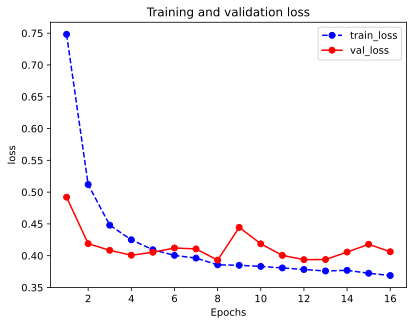

In [ ]:
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory["train_"+metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(dfhistory,"loss")

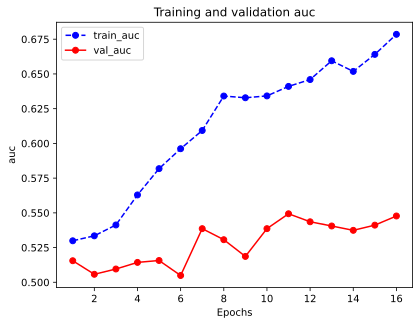

In [ ]:
plot_metric(dfhistory,"auc")

In [ ]:
model.evaluate(dl_val)

100%|██████████| 108/108 [00:09<00:00, 11.29it/s, val_auc=0.549, val_loss=0.4]


{'val_loss': 0.40048731215022226, 'val_auc': 0.5493427515029907}

In [ ]:
labels = torch.tensor([x["label"] for x in ds_val])
preds = model.predict(dl_val)
val_auc = roc_auc_score(labels.cpu().numpy(),preds.cpu().numpy())
print(val_auc)

0.5493352929635059
